In [1]:
import yaml
import time
import random
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
import time
from envs.photo_env import PhotoEnhancementEnv
from envs.photo_env import PhotoEnhancementEnvTest
from sac.sac_algorithm import SAC
import multiprocessing as mp
try:
    mp.set_start_method('spawn', force=True)
except RuntimeError:
    pass  


In [2]:
with open("configs/hyperparameters.yaml") as f:
    config_dict =yaml.load(f, Loader=yaml.FullLoader)

with open("configs/config.yaml") as f:
    env_config_dict =yaml.load(f, Loader=yaml.FullLoader)
    
class Config(object):
    def __init__(self, dictionary):
        self.__dict__.update(dictionary)
sac_config = Config(config_dict)
env_config = Config(env_config_dict)
SEED = sac_config.seed

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = sac_config.torch_deterministic
torch.autograd.set_detect_anomaly(True)

In [3]:
env = PhotoEnhancementEnv(
                    batch_size=env_config.train_batch_size,
                    imsize=env_config.imsize,
                    training_mode=True,
                    done_threshold=env_config.threshold_psnr,
                    pre_encode=False,
                    edit_sliders=env_config.sliders_to_use,
                    features_size=env_config.features_size,
                    logger=None
)
test_env = PhotoEnhancementEnvTest(
                    batch_size=env_config.test_batch_size,
                    imsize=env_config.imsize,
                    training_mode=False,
                    done_threshold=env_config.threshold_psnr,
                    pre_encode=False,
                    edit_sliders=env_config.sliders_to_use,
                    features_size=env_config.features_size,
                    logger=None
)
print(f'Sliders used {env.edit_sliders}')
print(f'Number of sliders used { env.num_parameters}')
print(f'Sliders used {test_env .edit_sliders}')
print(f'Number of sliders used {test_env .num_parameters}')

Sliders used ['contrast', 'exposure', 'shadows', 'highlights', 'whites']
Number of sliders used 5
Sliders used ['contrast', 'exposure', 'shadows', 'highlights', 'whites']
Number of sliders used 5


In [4]:
run_name = f"{sac_config.exp_name}__{sac_config.seed}__{int(time.time())}"
writer = SummaryWriter(f"runs/{run_name}")
writer.add_text(
    "hyperparameters",
    "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(sac_config).items()])),
)
agent = SAC(env,sac_config,writer)

(32, 5) -5


/home/zakaria/miniconda3/envs/photoen/lib/python3.11/site-packages/torch/_compile.py:24: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return torch._dynamo.disable(fn, recursive)(*args, **kwargs)


In [5]:
from datetime import datetime
c = datetime.now()
print(c)

2024-07-07 17:21:46.965542


In [6]:
from datetime import datetime

# Get the current time
c = datetime.now()

# Round the seconds to two decimal places
rounded_seconds = round(c.second + c.microsecond / 1e6, 2)

# Create a new datetime string with the rounded seconds
formatted_time = c.strftime('%Y-%m-%d_%H:%M:') + f'{rounded_seconds:05.2f}'

formatted_time

'2024-07-07_17:21:46.97'

In [7]:
agent.start_time = time.time()
for i in range(1):
    episode_count = 0
    
    agent.reset_env()
    envs_mean_rewards =[]
    while True:     
        episode_count+=1
        agent.global_step+=1
        rewards,batch_dones = agent.train()
        envs_mean_rewards.append(rewards.mean().item())
        if(batch_dones==True).any():
            # print('one done')
            # print(agent.state.shape,agent.env.sub_env_running.shape)
            num_env_done = int(batch_dones.sum().item())
            agent.writer.add_scalar("charts/num_env_done", num_env_done , agent.global_step)
        if agent.global_step % 100 == 0:
            ens_mean_episodic_return = sum(envs_mean_rewards)
            agent.writer.add_scalar("charts/mean_episodic_return", ens_mean_episodic_return, agent.global_step)

        if (batch_dones==True).all()==True or episode_count==sac_config.max_episode_timesteps:
            episode_count=0           
            break 

    if agent.global_step%200==0:
        # agent.backbone.eval()
        # with torch.no_grad():
        #     n_images = 5
        #     obs = test_env.reset() 
        #     actions = agent.actor.get_action(obs.to(sac_config.device))
        #     _,rewards,dones = test_env.step(actions[0].cpu())
        #     agent.writer.add_scalar("charts/test_mean_episodic_return", rewards.mean().item(), agent.global_step)
        #     agent.writer.add_images("test_images",test_env.state['source_image'][:n_images],0)
        #     agent.writer.add_images("test_images",test_env.state['enhanced_image'][:n_images],1)
        #     agent.writer.add_images("test_images",test_env.state['target_image'][:n_images],2)
        # agent.backbone.train()
        n_images = 5
        obs = test_env.reset() 
        actions = agent.act_eval(obs)
        _,rewards,dones = test_env.step(actions[0].cpu())
        agent.writer.add_scalar("charts/test_mean_episodic_return", rewards.mean().item(), agent.global_step)
        agent.writer.add_images("test_images",test_env.state['source_image'][:n_images],0)
        agent.writer.add_images("test_images",test_env.state['enhanced_image'][:n_images],1)
        agent.writer.add_images("test_images",test_env.state['target_image'][:n_images],2)

In [8]:
def save_actor_head(actor_model, file_path):
    # Extract the state dictionaries of the relevant layers
    actor_head_state_dict = {
        'fc1': actor_model.fc1.state_dict(),
        'fc2': actor_model.fc2.state_dict(),
        'fc_mean': actor_model.fc_mean.state_dict(),
        'fc_logstd': actor_model.fc_logstd.state_dict()
    }
    # Save the state dictionaries to a file
    torch.save(actor_head_state_dict, file_path)

def load_actor_head(actor_model, file_path):
    # Load the state dictionaries from the file
    actor_head_state_dict = torch.load(file_path)
    # Load the state dictionaries into the model
    actor_model.fc1.load_state_dict(actor_head_state_dict['fc1'])
    actor_model.fc2.load_state_dict(actor_head_state_dict['fc2'])
    actor_model.fc_mean.load_state_dict(actor_head_state_dict['fc_mean'])
    actor_model.fc_logstd.load_state_dict(actor_head_state_dict['fc_logstd'])

def save_critic_head(critic_model, file_path):
    # Extract the state dictionaries of the relevant layers
    critic_head_state_dict = {
        'fc1': critic_model.fc1.state_dict(),
        'fc2': critic_model.fc2.state_dict(),
        'fc3': critic_model.fc3.state_dict()
    }
    # Save the state dictionaries to a file
    torch.save(critic_head_state_dict, file_path)

def load_critic_head(critic_model, file_path):
    # Load the state dictionaries from the file
    critic_head_state_dict = torch.load(file_path)
    # Load the state dictionaries into the model
    critic_model.fc1.load_state_dict(critic_head_state_dict['fc1'])
    critic_model.fc2.load_state_dict(critic_head_state_dict['fc2'])
    critic_model.fc3.load_state_dict(critic_head_state_dict['fc3'])

In [9]:
from sac.sac_networks import Actor, SoftQNetwork, Backbone

with open("configs/inference_config.yaml") as f:
    inf_config_dict =yaml.load(f, Loader=yaml.FullLoader)
inference_config = Config(inf_config_dict)

class InferenceAgent:

    def __init__(self,inference_env, inference_args):
        self.args =inference_args
        self.device = inference_args.device
        self.backbone = Backbone().to(self.device)
        self.env = inference_env
        
    def load_backbone (self,backbone_path):
        self.backbone.load_state_dict(torch.load(backbone_path))
        self.actor = Actor(self.env,self.backbone).to(self.device)
        self.qf1 = SoftQNetwork(self.env,self.backbone).to(self.device)
        self.qf2 = SoftQNetwork(self.env,self.backbone).to(self.device)
        self.backbone.eval()

    def load_actor_weights(self,actor_path):
        load_actor_head(self.actor, actor_path)
        self.actor.eval()
        
    def load_critics_weights(self,qf1_path,qf2_path):  
        load_critic_head(self.qf1, qf1_path)
        load_critic_head(self.qf2, qf2_path)
        self.qf1.eval()
        self.qf2.eval()

    def act(self,obs):
        with torch.inference_mode():
            actions = self.actor.get_action(obs.to(self.device))   
        return actions
    
    def critic(self,obs,actions):
        with torch.inference_mode():
            qf1_pi = self.qf1(obs.to(self.device), actions.to(self.device))
            qf2_pi = self.qf2(obs.to(self.device), actions.to(self.device))
            value = torch.min(qf1_pi, qf2_pi)

        return value
    
inference_env = PhotoEnhancementEnvTest(
                    batch_size=env_config.test_batch_size,
                    imsize=env_config.imsize,
                    training_mode=False,
                    done_threshold=env_config.threshold_psnr,
                    pre_encode=False,
                    edit_sliders=env_config.sliders_to_use,
                    features_size=env_config.features_size,
                    logger=None
)
inf_agent =InferenceAgent(inference_env, inference_config)

In [10]:
# torch.save(agent.backbone.state_dict(), 'backbone.pth')
# save_actor_head(agent.actor, 'actor_head.pth')
# save_critic_head(agent.qf1, 'qf1_head.pth')
# save_critic_head(agent.qf2, 'qf2_head.pth')
# inf_agent.load_backbone('backbone.pth')
# inf_agent.load_actor_weights('actor_head.pth')
# inf_agent.load_critics_weights('qf1_head.pth','qf2_head.pth')


In [11]:
fagent = Actor(inference_env,Backbone())
fagent.load_state_dict(torch.load('actor_model_5param.pth'))
torch.save(fagent.features_extractor.state_dict(), 'backbone_5param.pth')
save_actor_head(fagent, 'actor_head_5param.pth')
inf_agent.load_backbone('backbone_5param.pth')
inf_agent.load_actor_weights('actor_head_5param.pth')

In [12]:
import cv2
import torch
import matplotlib.pyplot as plt
source_image = cv2.imread("sample_images/a0676-kme_609_original.jpg")
target_image = cv2.imread("sample_images/a0676-kme_609_C.jpg")
source_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB) /255.0
target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB) /255.0

input = torch.Tensor(source_image).unsqueeze(0)

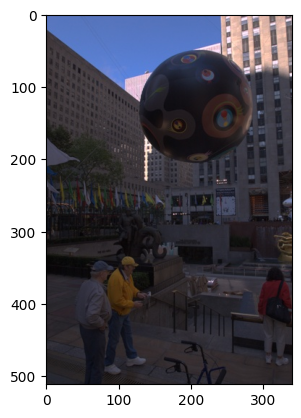

In [13]:
plt.imshow(source_image)

In [14]:
SLIDERS_TO_USE = ["contrast","exposure","shadows","highlights","whites"]
from envs.new_edit_photo import PhotoEditor
import matplotlib.pyplot as plt
photo_editor = PhotoEditor(SLIDERS_TO_USE)
photo_editor_UIE = PhotoEditor()

In [15]:
param_UIE = torch.tensor([0.125, 0.125, 0.375, 0.125, 0., 0.0625, 0.9375, 0.375, 0.0625, 0., 0.125, 0.125]).unsqueeze(0)

In [16]:
inf_agent.backbone.eval()
inf_agent.actor.eval()
with torch.no_grad():
    parameters = inf_agent.act(input.permute(0,3,1,2).cuda())
    enhanced_image = photo_editor(input.cpu(),parameters[2].cpu())
    enhanced_image_UIE = photo_editor_UIE(input.cpu(),param_UIE.cpu())
parameters

(tensor([[ 0.3236,  0.2236, -0.8049, -0.2539, -0.0048]], device='cuda:0'),
 tensor([[2.8029]], device='cuda:0'),
 tensor([[ 0.3541,  0.1380, -0.7736, -0.1186, -0.0346]], device='cuda:0'))

In [17]:
target_tensor = torch.Tensor(target_image).unsqueeze(0)
PSNR_UIE = test_env.compute_rewards(enhanced_image_UIE,target_tensor).item()+50
PSNR_OURS = test_env.compute_rewards(enhanced_image,target_tensor).item()+50

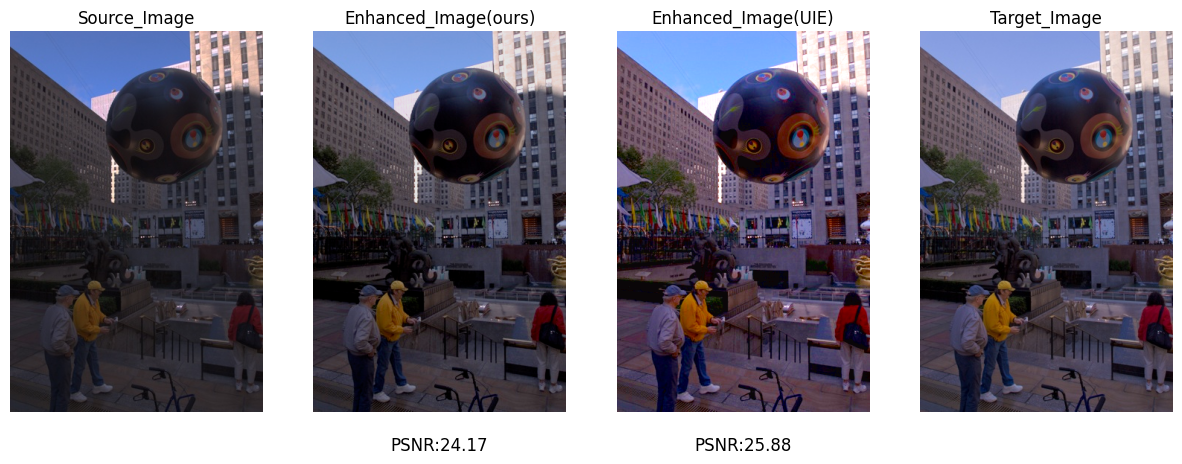

In [18]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
labels =["Source_Image","Enhanced_Image(ours)","Enhanced_Image(UIE)","Target_Image"]
imgs =[source_image,enhanced_image[0],enhanced_image_UIE[0],target_image]
PSNRS = [PSNR_OURS,PSNR_UIE]
for index,(img,label) in enumerate(zip(imgs,labels)):
    axes[index].imshow(img)
    axes[index].set_title(label)
    axes[index].axis('off')
    if index==1 or index==2:
        axes[index].text(0.5, -0.1, f'PSNR:{round(PSNRS[index-1],2)}', size=12, ha='center', transform=axes[index].transAxes)

In [21]:
from envs.env_dataloader import create_dataloaders
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torchmetrics.image import StructuralSimilarityIndexMeasure
ssim_metric = StructuralSimilarityIndexMeasure()
test_512 = create_dataloaders(batch_size=1,image_size=64,train=False,pre_encode= False,shuffle=False,resize=False)
transform = transforms.Compose([
            v2.Resize(size = (64,64), interpolation= transforms.InterpolationMode.BICUBIC),
        ])
PSNRS = []
SSIM = []
for i,t in test_512:
    input = i/255.0
    target = t/255.0 
    parameters = inf_agent.act(transform(input))
    enhanced_image = photo_editor((input.permute(0,2,3,1)).cpu(),parameters[2].cpu())
    psnr = test_env.compute_rewards(enhanced_image.permute(0,3,1,2),target).item()+50
    ssim = ssim_metric(enhanced_image.permute(0,3,1,2),target).item()
    PSNRS.append(psnr)
    SSIM.append(ssim)
print(f'Mean PSNR on MIT 5K Dataset {round(np.mean(PSNRS),2)}')
print(f'Mean SSIM on MIT 5K Dataset {round(np.mean(SSIM),3)}')

Mean PSNR on MIT 5K Dataset 22.2
Mean SSIM on MIT 5K Dataset 0.857
